first of all; importing the images, i'm using imread from scipy.

In [1]:
from __future__ import print_function
from scipy.misc import imread
import glob
import numpy as np
from os import path, walk
hook = True
imagesList = []
pathList = []

pathbase = "../bee_imgs/bee_imgs"
for impath in glob.glob(path.join(pathbase, "*.png")):
    image = imread(impath, mode='RGB')
    image = np.divide(image, 255)
    imagesList.append(image.astype(np.float64))
    filename = impath[impath.rfind('/')+1:]
    pathList.append(filename)


/home/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':


imagesList now holds all the images of the bees, pathList holds the corresponding path names. let's check if they have the same size;

In [2]:
print(len(pathList))
print(len(imagesList))

5172
5172


Great! So no problems there. Next up is some preprocessing, as the data is heavily imbalanced. For this we'll need the supplied csv file that holds the classes. pandas has a nifty function to read csv's directly to a dataframe, which we'll use to get our classnames into a dictionary with their corresponding file names, that way we can easily link them to the images later on.

In [3]:
import pandas as pd
beeMetaData = pd.read_csv('../bee_data.csv')
beeTypes = dict(zip(beeMetaData.file, beeMetaData.health))

As can be seen below, this is the current distribution of the dataset. we're trimming off 'missing queen' and scaling 'healthy' down to a round 400. 

In [4]:
labels = set(beeTypes.values())
for i in labels:
    print(i, sum(value == i for value in beeTypes.values()))

Varroa, Small Hive Beetles 472
few varrao, hive beetles 579
ant problems 457
healthy 3384
missing queen 29
hive being robbed 251


In [5]:
healthybees = []
for k,v in beeTypes.items():
     if v == "healthy" and len(healthybees) < 400:
        healthybees.append(k)

remlist = []
for k,v in beeTypes.items():
    if v == "missing queen":
        remlist.append(k)
    if v == "healthy" and k not in healthybees:
        remlist.append(k)
for remove in remlist:
    del beeTypes[remove]

all done! let's take a look at the distribution now;

In [6]:
labels = set(beeTypes.values())
for i in labels:
    print(i, sum(value == i for value in beeTypes.values()))

Varroa, Small Hive Beetles 472
few varrao, hive beetles 579
ant problems 457
healthy 400
hive being robbed 251


now that that is out of the way, let's drop the images that we don't want from the set

In [7]:
counter = 0
to_remove = []
for i in pathList:
    if i in beeTypes.keys():
        pass
    else:
        to_remove.append(counter)
    counter += 1

print(len(to_remove))

#removing indices from list (in reverse as not to throw off index order)
if hook == True:
    for index in sorted(to_remove, reverse=True):
        del imagesList[index]
        del pathList[index]
    hook = False

3013


In [8]:
print(len(imagesList))
print(len(beeTypes.values()))

2159
2159


now that we are left with only the values we want, we can resize all images in the set. 

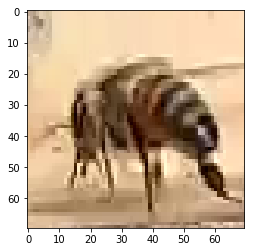

In [9]:
import cv2
resized = []
for i in imagesList:
    resized.append(cv2.resize(i,dsize=(70,70),interpolation=cv2.INTER_NEAREST))
#also, let's take a look at the bee to see if it's still in good shape
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(resized[9])

he's a bit snug, but the network won't care. now, let's get to some cnn stuff.

In [10]:
import datetime

shapex = 70
shapey = 70
channels = 3
stepsNN = 50

#defining a list outside the function so we can log the tf.argmax output without it getting lost to 
#the tensorflow clutter.
#It will hold the predictions for each iteration of the 
#kfold, which means we can use it for a classification report later
outputNN = []

def cnn_fn(features, labels, mode):
    # input (numpy array filled with images with shape: shapex, shapey)
    input_layer = tf.reshape(features["x"], [-1, shapex, shapey, channels])

    # convolutional layer 1 (kernel size = 5x5)
    convo1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=100,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu
    )

    # pooling layer 1; 50 percent image size reduction
    pool1 = tf.layers.max_pooling2d(inputs=convo1, pool_size=[2, 2], strides=2 )

    convo2 = tf.layers.conv2d(
        inputs=pool1,
        filters=200,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu
    )

    pool2 = tf.layers.max_pooling2d(inputs=convo2, pool_size=[2, 2], strides=2)

    flat = tf.reshape(pool2, [-1, int(shapex/4) * int(shapey/4) * 200])

    dense = tf.layers.dense(inputs=flat, units=2000, activation=tf.nn.relu)

    # small dropout
    drop = tf.layers.dropout(
        inputs=dense, rate=0.2,training=mode == tf.estimator.ModeKeys.TRAIN
    )

    # five classes
    logits = tf.layers.dense(inputs=drop, units=5)

    pred = {
        "classes" : tf.argmax(input=logits, axis=1),
        "probabilities" : tf.nn.softmax(logits, name="softmaxt")
    }
    #interM = tf.argmax(input=logits, axis=1)
    #print(interM)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=pred)

        # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.003)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=pred["classes"])}
    
    #confusion = tf.confusion_matrix(labels=labels, predictions=pred["classes"],num_classes=5)
    
    #print('Confusion Matrix: \n\n', tf.Tensor.eval(confusion,feed_dict=None,session=sess))
    

    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

def runNN(train_data, eval_data, train_labels, eval_labels):
    cnn_classifier = tf.estimator.Estimator(model_fn=cnn_fn,model_dir='models/bees')

    tensors_to_log = {"probabilities":"softmax_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x":train_data},
        y=train_labels,
        batch_size=100,
        num_epochs=20,
        shuffle=True)
    start_time = time.time()
    cnn_classifier.train(input_fn=train_input_fn,steps=stepsNN)
    print("Time taken to train: "+str((time.time()-start_time)))
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x":eval_data},
        y=eval_labels,
        num_epochs=1,
        shuffle=False)
    eval_results = cnn_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)
    stopMadness = cnn_classifier.predict(input_fn=eval_input_fn)
    for x,y in enumerate(stopMadness):
        outputNN.append(y["classes"])
        

a simple CNN, now for the input... 

In [11]:
from operator import itemgetter 
import tensorflow as tf
import time
from sklearn.model_selection import KFold

In [29]:
kf = KFold(n_splits=10, shuffle=True,random_state=22)
classList = []
for i in pathList:
    classList.append(beeTypes[i])

#mapping the classList items to integers
y = []
for i in classList:
    y.append((list(labels)).index(i))

    
#defining a list for evaluation of the performance of the net
evaly = []

from sklearn.model_selection import train_test_split
kftrainX, valX, kftrainy, valy = train_test_split(resized, y, test_size=0.2, random_state=42)
evaly = valy

#using kfold on the split version of the network, final eval will be done using the validation set.

for trainIndex, testIndex in kf.split(kftrainy):

    trainX = []
    trainy = []
    testX = []
    testy = []
    for i in trainIndex:
        trainX.append(kftrainX[i])
        trainy.append(kftrainy[i])
    for i in testIndex:
        testX.append(kftrainX[i])
        testy.append(kftrainy[i])
        #evaly.append(y[i])
    
    imglisttrain = np.asarray(trainX, dtype=np.float64)
    imglisttest = np.asarray(testX, dtype=np.float64)
    pathlisttest = np.asarray(testy, dtype=np.int32)
    pathlisttrain = np.asarray(trainy, dtype=np.int32)
    if counter < 9:
        runNN(imglisttrain, imglisttest, pathlisttrain, pathlisttest)
    else:
        valX = np.asarray(valX, dtype=np.float64)
        valy = np.asarray(valy, dtype=np.int32)
        print("final eval!")
        runNN(imglisttrain, valX, pathlisttrain, valy)
        


final eval!
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/bees', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2bb4ba7a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:G

INFO:tensorflow:Saving checkpoints for 150 into models/bees/model.ckpt.
INFO:tensorflow:loss = 0.23446330428123474, step = 151
INFO:tensorflow:Saving checkpoints for 200 into models/bees/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1169973686337471.
Time taken to train: 281.0172367095947
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-28-12:59:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/bees/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-28-12:59:28
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.8564815, global_step = 200, loss = 0.4178289
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: models/bees/model.ckpt-200
{'accuracy': 0.8564815, 'loss': 0.4178289, 'global_step': 200}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done cal

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
final eval!
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/bees', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2bb5498320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:D

as seen above, the model scores an accuracy of 86 percent with bees it has never seen before, pretty impressive. let's do some more classification, this time with a random forest to compare if the results are very different at all.

i used sklearns random forest, because it's easy to set up and reliable.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(resized, y, test_size=0.2, random_state=42)
X_train_flattened = []
X_test_flattened = []
for i in X_train:
    X_train_flattened.append(i.flatten('F'))
for i in X_test:
    X_test_flattened.append(i.flatten('F'))
    
rfc = RandomForestClassifier()
rfc = rfc.fit(X_train_flattened,y_train)
predictions = rfc.predict(X_test_flattened)

print("Random forest score:")
print(accuracy_score(y_test, predictions))

/home/tim/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest score:
0.8101851851851852


A little lower than the CNN. Now for some assessment of the models; starting with a classification report of the random forest:

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))
print("corresponding labels:")
print(labels)

              precision    recall  f1-score   support

           0       0.68      0.65      0.66        88
           1       0.65      0.74      0.69       102
           2       0.96      0.95      0.95       100
           3       0.89      0.94      0.91        84
           4       0.98      0.76      0.85        58

   micro avg       0.81      0.81      0.81       432
   macro avg       0.83      0.81      0.82       432
weighted avg       0.82      0.81      0.81       432

corresponding labels:
{'Varroa, Small Hive Beetles', 'few varrao, hive beetles', 'ant problems', 'healthy', 'hive being robbed'}


as seen above, the random forest model scores poorly on the classification of 'few varrao, hive beetles' and 'Varroa, Small Hive Beetles'. The average score is good but that's mostly thanks to the strong classification of the 'healthy' and 'ant problems' labels.

let's see what the confusion matrices of the neural net look like;

In [36]:
#grabbing the last 432 tags from the outputNN list, as these hold the labels that correspond to the evaly list.
print(classification_report(evaly, outputNN[-len(evaly):]))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        88
           1       0.81      0.77      0.79       102
           2       1.00      0.87      0.93       100
           3       0.94      0.92      0.93        84
           4       0.82      0.88      0.85        58

   micro avg       0.86      0.86      0.86       432
   macro avg       0.87      0.87      0.87       432
weighted avg       0.87      0.86      0.86       432



an impressive improvement in comparison with the random forest model. But even though the model performs significantly better, you can still tell that the first 2 tags are not as strongly classified as the others. however, they are still quite a ways above random.